In [1]:
# importing modules

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import logging
import sys
import pickle
import joblib
import os
import gc

from itertools import product

from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization

from tensorflow.keras.regularizers import l1, l2

from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

# tf.config.optimizer.set_experimental_options({'auto_mixed_precision': True})

# tf.config.set_visible_devices([], 'GPU')

# physical_devices = tf.config.list_physical_devices('GPU')

tf.test.gpu_device_name()
tf.device('/GPU:0')
# tf.device('/CPU:0')

import optuna
from optuna.samplers import TPESampler

2024-11-28 16:59:17.139835: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-11-28 16:59:19.940872: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 16:59:19.950930: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-11-28 16:59:20.233152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 16:59:20.233281: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name:

In [2]:

# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")
from tensorflow.python.platform import build_info

print("CUDA version:", build_info.build_info['cuda_version'])
print("cuDNN version:", build_info.build_info['cudnn_version'])


TensorFlow Version: 2.5.0
CUDA version: 11.2
cuDNN version: 8


In [10]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [2]:
num_classes = 19 #0 - 18
np.random.seed(441) #setting seed
img_rows, img_cols = 28, 56 #image dimensions

In [17]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X = np.concatenate([x_train, x_test])
Y = np.concatenate([y_train, y_test])

X = X.astype('float32')
X /= 255


def dataset(X, Y, output=100000):
    pairs_per_combination = output//100
    imgs = []
    labels = []
    l1 = []
    l2 = []
    sample_idx=0
    for i in range(10):
        for j in range(10):
            idxl1 = np.where(Y == i)[0]
            idxl2 = np.where(Y == j)[0]
            for k in range(pairs_per_combination):
                idx1 = np.random.choice(idxl1)
                idx2 = np.random.choice(idxl2)
                combined_img = np.hstack((X[idx1], X[idx2]))
                combined_label = i+j
                imgs.append(combined_img)
                labels.append(combined_label)
                l1.append(i)
                l2.append(j)
            sample_idx += 1
    shuffle_idx = np.random.permutation((len(imgs)))
    imgs = np.array(imgs)[shuffle_idx]
    labels = np.array(labels)[shuffle_idx]
    l1 = np.array(l1)[shuffle_idx]
    l2 = np.array(l2)[shuffle_idx]
    return imgs, labels, l1, l2

X, Y, D1, D2 = dataset(X, Y)

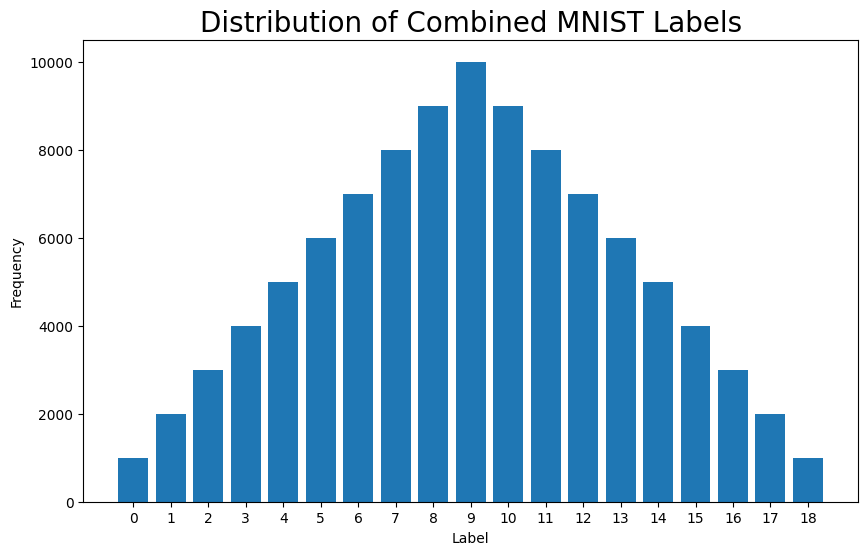

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(Y, bins=np.arange(20) - 0.5, rwidth=0.8)
ax.set_title('Distribution of Combined MNIST Labels', fontsize=20)
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')
ax.set_xticks(range(19))  # Labels from 0 to 18
fig.savefig('Y_dist.png')
plt.show()

In [23]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=(1-train_ratio), random_state=441)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=(test_ratio/(val_ratio+test_ratio)), random_state=441)

print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train shape: (80000, 28, 56)
x_val shape: (10000, 28, 56)
x_test shape: (10000, 28, 56)
y_train shape: (80000,)
80000 train samples
10000 test samples
10000 validation samples


In [24]:
with open('x_train_nn.pickle', 'wb') as f:
    pickle.dump(x_train, f)

with open('y_train_nn.pickle', 'wb') as f:
    pickle.dump(y_train, f)
    
with open('x_test_nn.pickle', 'wb') as f:
    pickle.dump(x_test, f)
    
with open('y_test_nn.pickle', 'wb') as f:
    pickle.dump(y_test, f)

with open('x_val_nn.pickle', 'wb') as f:
    pickle.dump(x_val, f)
    
with open('y_val_nn.pickle', 'wb') as f:
    pickle.dump(y_val, f)

In [3]:
with open('x_train_nn.pickle', 'rb') as f:
    x_train = pickle.load(f)

with open('y_train_nn.pickle', 'rb') as f:
    y_train = pickle.load(f)
    
with open('x_test_nn.pickle', 'rb') as f:
    x_test = pickle.load(f)
    
with open('y_test_nn.pickle', 'rb') as f:
    y_test = pickle.load(f)

with open('x_val_nn.pickle', 'rb') as f:
    x_val = pickle.load(f)
    
with open('y_val_nn.pickle', 'rb') as f:
    y_val = pickle.load(f)

In [4]:
label = [y_train, y_test, y_val]
labels = [np.argmax(y, axis=1) for y in label]
labels_title = ["training", "testing", "validating"]

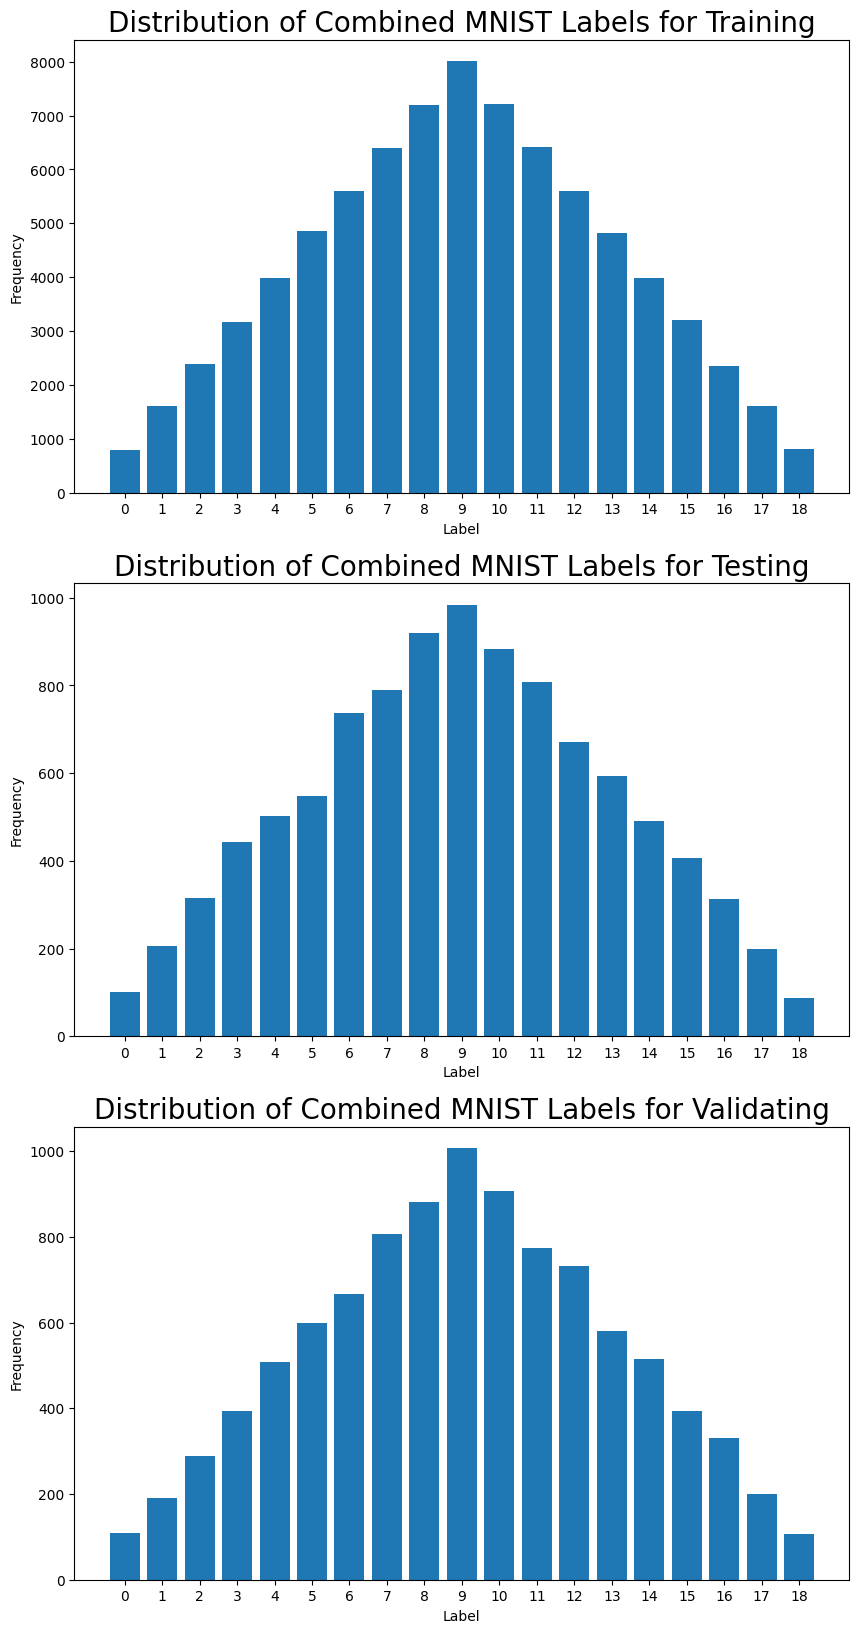

In [5]:
fig, axs = plt.subplots(3, figsize=(10, 20))
for i in range(len(labels)):
    axs[i].hist(labels[i], bins=np.arange(20) - 0.5, rwidth=0.8)
    axs[i].set_title(f'Distribution of Combined MNIST Labels for {labels_title[i].capitalize()}', fontsize=20)
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xticks(range(19))

fig.savefig('Y_split_dist.png')
plt.show()

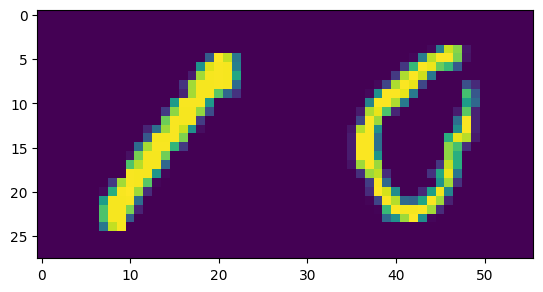

1


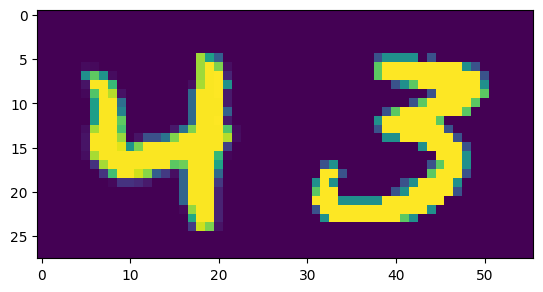

7


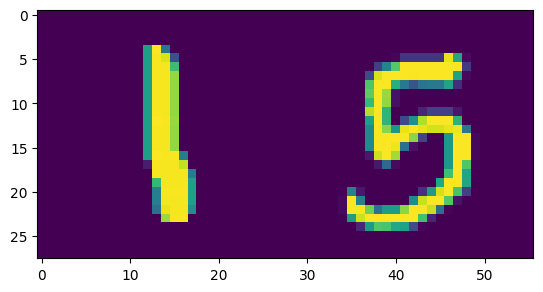

6


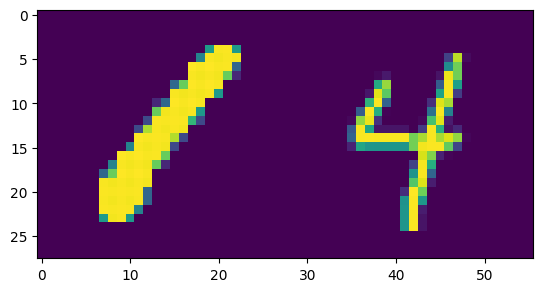

5


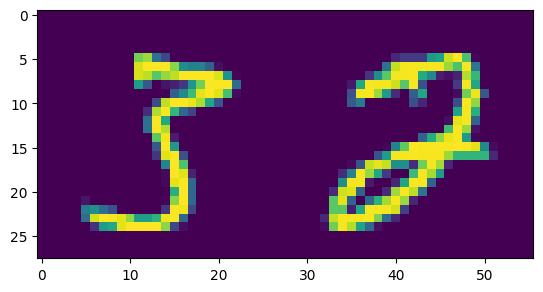

5


In [6]:
for i in range(5):
    plt.imshow(x_train[i])
    plt.show()
    print(np.where(y_train[i]==1)[0][0])

In [4]:
num = ""
s_name = f"study{num}"
m_name = f"model{num}"
smp_name = f"sampler{num}"
h_name = f"history{num}"

In [5]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.01, 0.5)
    l2_regularization = trial.suggest_float('l2_regularization', 1e-4, 1e-3)
    n_layers = trial.suggest_int('n_layers', 4, 6)
    batch_size = trial.suggest_int('batch_size', 16, 256)
    
    model = Sequential()
    model.add(Flatten(input_shape=(img_rows, img_cols)))

    neurons = [2**n * 64 for n in range(n_layers)][::-1]

    for i in range(n_layers):
        model.add(Dense(neurons[i], activation='relu', kernel_regularizer=l2(l2_regularization)))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())

    model.add(Dense(num_classes,activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
    model_checkpoint = ModelCheckpoint(f"nn_best_{m_name}.keras", save_best_only=True, monitor='val_loss', mode='min', verbose=0)
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=batch_size, verbose=0, callbacks=[model_checkpoint, early_stopping, reduce_lr])
    
    score = model.evaluate(x_test, y_test, verbose=0)
    accuracy = score[1]

    backend.clear_session()
    del model
    gc.collect()

    return accuracy

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=441))

study.optimize(objective, n_trials=10, show_progress_bar=True)

[I 2024-11-28 17:00:01,445] A new study created in memory with name: no-name-a809fbb7-ccaa-471e-969c-63e600a6c450


  0%|          | 0/10 [00:00<?, ?it/s]

2024-11-28 17:00:02.029100: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 501760000 exceeds 10% of free system memory.
2024-11-28 17:00:02.453356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-11-28 17:00:02.456190: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2918400000 Hz
2024-11-28 17:00:03.404566: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12845056 exceeds 10% of free system memory.
2024-11-28 17:00:03.415367: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12845056 exceeds 10% of free system memory.
2024-11-28 17:00:03.444370: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12845056 exceeds 10% of free system memory.
2024-11-28 17:00:03.445969: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12845056 exceeds 10% of free system memory.
2024-11-28 17:00:03.501516:

[I 2024-11-28 17:03:44,400] Trial 0 finished with value: 0.7537000179290771 and parameters: {'learning_rate': 0.00012640894137902795, 'dropout_rate': 0.4371522935380698, 'l2_regularization': 0.00018855547039574826, 'n_layers': 6, 'batch_size': 43}. Best is trial 0 with value: 0.7537000179290771.
[I 2024-11-28 17:05:16,682] Trial 1 finished with value: 0.8572999835014343 and parameters: {'learning_rate': 0.00010566642239214952, 'dropout_rate': 0.2243604801556688, 'l2_regularization': 0.0009855369987515374, 'n_layers': 4, 'batch_size': 92}. Best is trial 1 with value: 0.8572999835014343.
[I 2024-11-28 17:06:12,666] Trial 2 finished with value: 0.1615999937057495 and parameters: {'learning_rate': 1.0343391251100634e-05, 'dropout_rate': 0.3447319872704496, 'l2_regularization': 0.0009075346959392968, 'n_layers': 6, 'batch_size': 158}. Best is trial 1 with value: 0.8572999835014343.
[I 2024-11-28 17:07:02,650] Trial 3 finished with value: 0.1354999989271164 and parameters: {'learning_rate': 

In [6]:
with open(f"nn_{s_name}.pkl", "wb") as f:
    pickle.dump(study, f)

In [7]:
print('Best trial:')
print(f' Value: {study.best_trial.value}')
print(' Params: ')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
 Value: 0.9326000213623047
 Params: 
    learning_rate: 0.00045116305382687745
    dropout_rate: 0.2123082524109884
    l2_regularization: 0.0005350854652602339
    n_layers: 6
    batch_size: 83


In [8]:
with open(f'nn_best_{s_name}_params.pkl', 'wb') as f:
    pickle.dump(study.best_trial.params, f)

In [9]:
with open(f'nn_best_{s_name}_params.pkl', 'rb') as f:
    params = pickle.load(f)

In [10]:
with open(f"nn_{smp_name}.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)

In [11]:
def create_and_save_model(params):
    model = Sequential()
    model.add(Flatten(input_shape=(img_rows, img_cols)))

    neurons = [2**n * 64 for n in range(params.get('n_layers'))][::-1]

    for i in range(params.get('n_layers')):
        model.add(Dense(neurons[i], activation='relu', kernel_regularizer=l2(params.get('l2_regularization'))))
        model.add(Dropout(params.get('dropout_rate')))
        model.add(BatchNormalization())

    model.add(Dense(num_classes,activation='softmax'))

    model.compile(optimizer=Adam(params.get('learning_rate')), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50,
                        batch_size=params.get('batch_size'), verbose=1)

    score = model.evaluate(x_test, y_test, verbose=0)
    accuracy = score[1]
    print(accuracy)
    model.save(f'nn_fitted_{m_name}.keras')
    with open(f'nn_fitted_{h_name}.pkl', "wb") as file:
        pickle.dump(history.history, file)

create_and_save_model(params)

Epoch 1/50
964/964 [==============================] - 13s 13ms/step - loss: 4.0889 - accuracy: 0.3177 - val_loss: 2.5950 - val_accuracy: 0.7411
Epoch 2/50
964/964 [==============================] - 15s 15ms/step - loss: 2.4859 - accuracy: 0.6925 - val_loss: 1.8112 - val_accuracy: 0.8436
Epoch 3/50
964/964 [==============================] - 11s 11ms/step - loss: 1.8220 - accuracy: 0.8067 - val_loss: 1.3941 - val_accuracy: 0.8908
Epoch 4/50
964/964 [==============================] - 11s 11ms/step - loss: 1.4716 - accuracy: 0.8470 - val_loss: 1.1749 - val_accuracy: 0.9038
Epoch 5/50
964/964 [==============================] - 13s 13ms/step - loss: 1.2499 - accuracy: 0.8695 - val_loss: 1.0041 - val_accuracy: 0.9198
Epoch 6/50
964/964 [==============================] - 11s 11ms/step - loss: 1.1104 - accuracy: 0.8818 - val_loss: 0.9142 - val_accuracy: 0.9247
Epoch 7/50
964/964 [==============================] - 11s 11ms/step - loss: 1.0270 - accuracy: 0.8896 - val_loss: 0.8684 - val_accuracy:

In [17]:
model = load_model(f'nn_fitted_{m_name}.keras')
sampler = pickle.load(open(f"nn_{smp_name}.pkl", "rb"))
history = pickle.load(open(f"nn_fitted_{h_name}.pkl", "rb"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              3213312   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4

In [19]:
predictions = model.predict(x_test)
idxs = np.random.choice(len(x_test), size=10, replace=False)

/tmp/ipykernel_44819/902611111.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


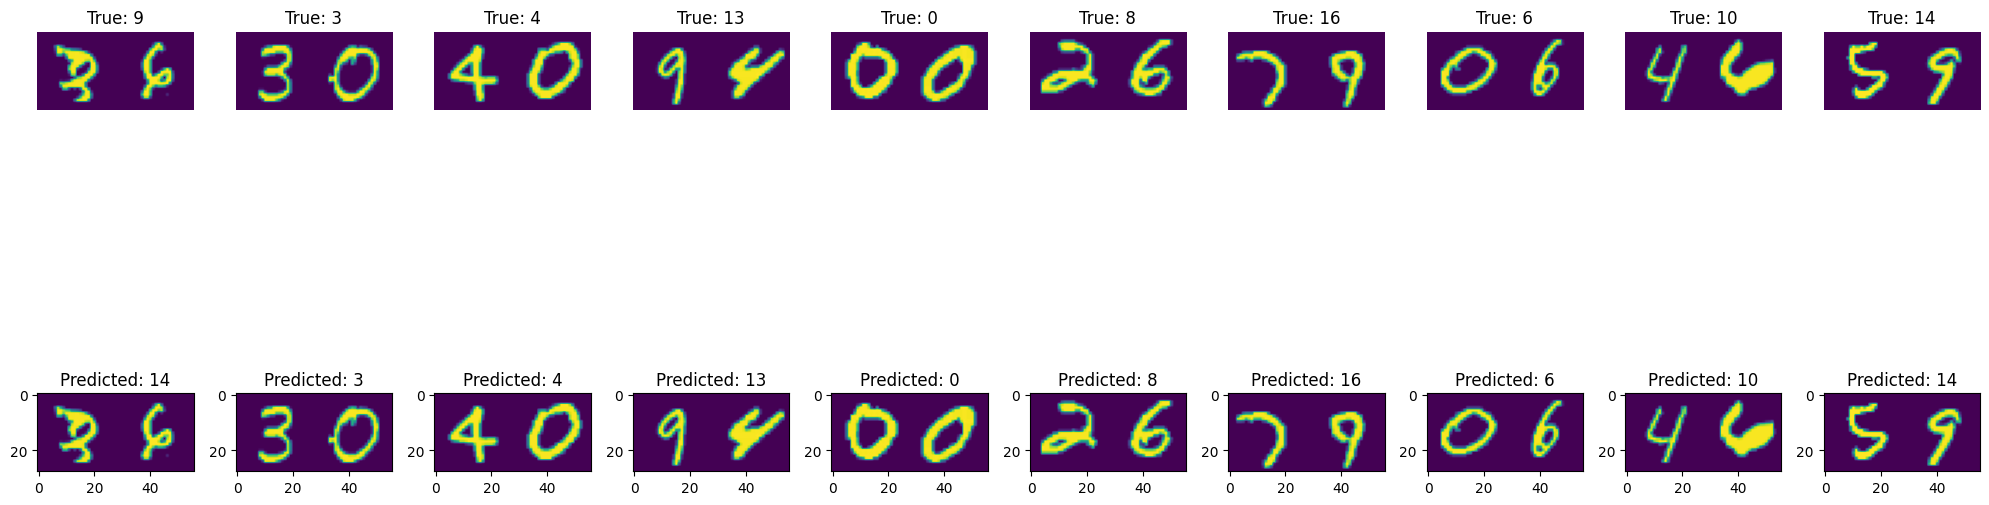

In [21]:
fig, axs = plt.subplots(2, 10, figsize=(20, 10))

for i in range(10):
    idx = idxs[i]
    axs[0, i].imshow(x_test[idx])
    axs[0, i].set_title(f"True: {np.argmax(y_test, axis=1)[idx]}")
    axs[0, i].axis('off')
    axs[1, i].imshow(x_test[idx])
    axs[1, i].set_title(f"Predicted: {np.argmax(predictions, axis=1)[idx]}")
    axs[0, i].axis('off')

fig.tight_layout()
fig.show()